In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
zeroyields = pd.read_excel('Zero yields.xlsx')
zeroyields = zeroyields.drop(0)
zeroyields = zeroyields.rename(columns={'Unnamed: 0': 'Date'})
zeroyields['Date'] = pd.to_datetime(zeroyields['Date'])
zeroyields.set_index('Date', inplace=True)
zeroyields = zeroyields.astype(float)
prices = (1 / (1 + zeroyields)) ** zeroyields.columns.astype(float)

In [3]:
zeroyields

,0.25,1,2,3,4,5,6,7,8,9,10
Date,,,,,,,,,,,
1961-06-30,0.023232,0.028967,0.032685,0.034938,0.036289,0.037122,0.037661,0.038033,0.038305,0.038514,0.038676
1961-07-31,0.022338,0.027608,0.032216,0.035024,0.036767,0.037894,0.038663,0.039221,0.039646,0.039983,0.040253
1961-08-31,0.023829,0.029823,0.033877,0.036375,0.037890,0.038830,0.039441,0.039861,0.040167,0.040399,0.040579
1961-09-29,0.022735,0.029220,0.033166,0.035365,0.036645,0.037435,0.037960,0.038336,0.038624,0.038852,0.039037
1961-10-31,0.022934,0.028752,0.032311,0.034600,0.036081,0.037075,0.037778,0.038306,0.038721,0.039058,0.039334
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,0.052158,0.052848,0.048542,0.045014,0.042661,0.041222,0.040396,0.039957,0.039756,0.039694,0.039711
2023-08-31,0.052652,0.052717,0.048227,0.045067,0.043087,0.041925,0.041285,0.040966,0.040840,0.040827,0.040874
2023-09-29,0.052849,0.053619,0.050147,0.047661,0.046282,0.045680,0.045554,0.045700,0.045990,0.046345,0.046718


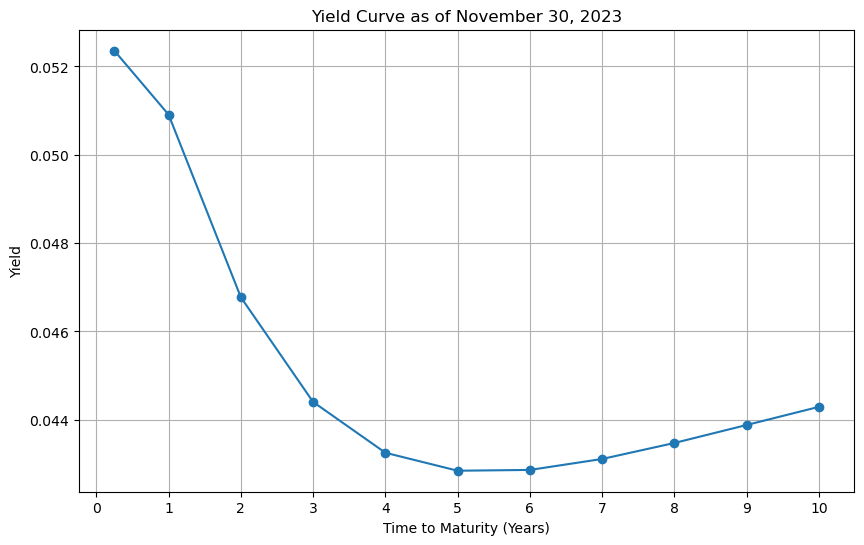

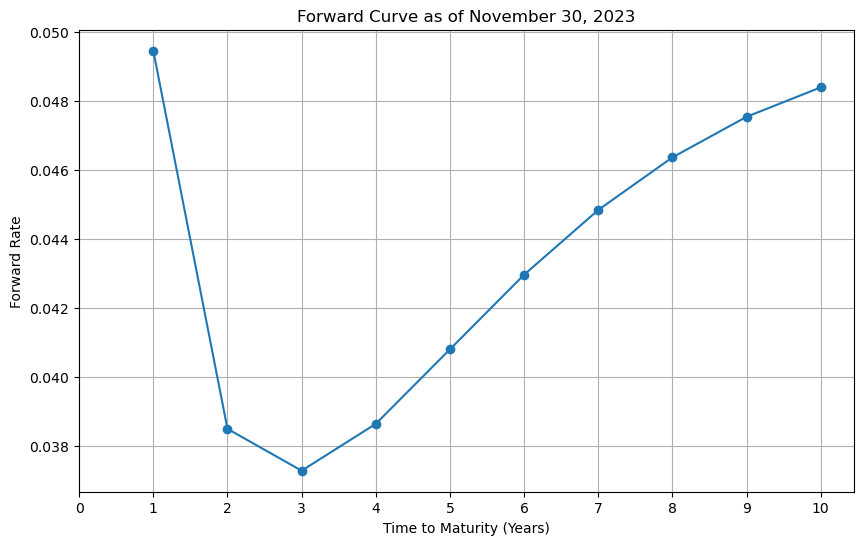

In [4]:

# Extract yields for November 30, 2023
nov_30_2023_yields = zeroyields.loc['2023-11-30']

# Plot the yield curve
plt.figure(figsize=(10, 6))
plt.plot(nov_30_2023_yields.index, nov_30_2023_yields.values, marker='o', linestyle='-')
plt.title('Yield Curve as of November 30, 2023')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Yield')
plt.grid(True)
plt.xticks(np.arange(0, 11, step=1))  # Assuming you want ticks for every year
plt.show()

# Calculate forward rates from the zero rates
# Forward rate from time t1 to t2 is given by f(t1, t2) = (R_t2 * t2 - R_t1 * t1) / (t2 - t1)
# forward_rates = [(nov_30_2023_yields[i] * (i+1) - nov_30_2023_yields[i-1] * i) /1 for i in range(1, len(nov_30_2023_yields))]
forward_rates = [(nov_30_2023_yields[i] * (i+1) - nov_30_2023_yields[i-1] * i) / (i+1 - i) for i in range(1, len(nov_30_2023_yields))]

# Plot the forward curve
plt.figure(figsize=(10, 6))
plt.plot(nov_30_2023_yields.index[1:], forward_rates, marker='o', linestyle='-')
plt.title('Forward Curve as of November 30, 2023')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Forward Rate')
plt.grid(True)
plt.xticks(np.arange(0, 11, step=1))  # Assuming you want ticks for every year
plt.show()

In [5]:
actual_yields = nov_30_2023_yields.values[1:]
short_rate = nov_30_2023_yields[0]
zero_yields = actual_yields[1:] 

In [6]:
expected_yields = []
for index, maturity in enumerate(forward_rates):
    if index == 0:
        expected_yield = ((forward_rates[index] - short_rate) / 0.75) + zero_yields[index]
    else:
        expected_yield = ((forward_rates[index] - short_rate) / index) + actual_yields[index]
    expected_yields.append(expected_yield)

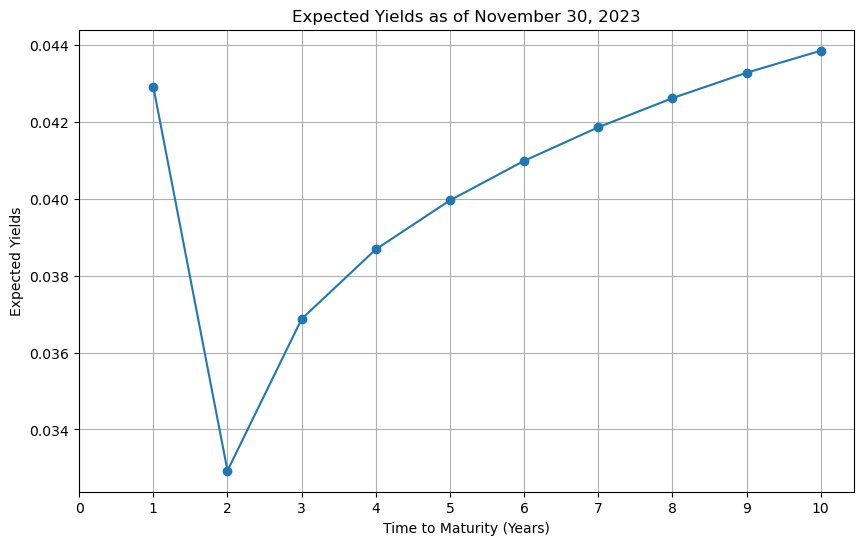

In [7]:
# Plot the forward curve
plt.figure(figsize=(10, 6))
plt.plot(nov_30_2023_yields.index[1:], expected_yields, marker='o', linestyle='-')
plt.title('Expected Yields as of November 30, 2023')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Expected Yields')
plt.grid(True)
plt.xticks(np.arange(0, 11, step=1))  # Assuming you want ticks for every year
plt.show()

In [8]:
zeroyields.columns

Index([0.25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='object')

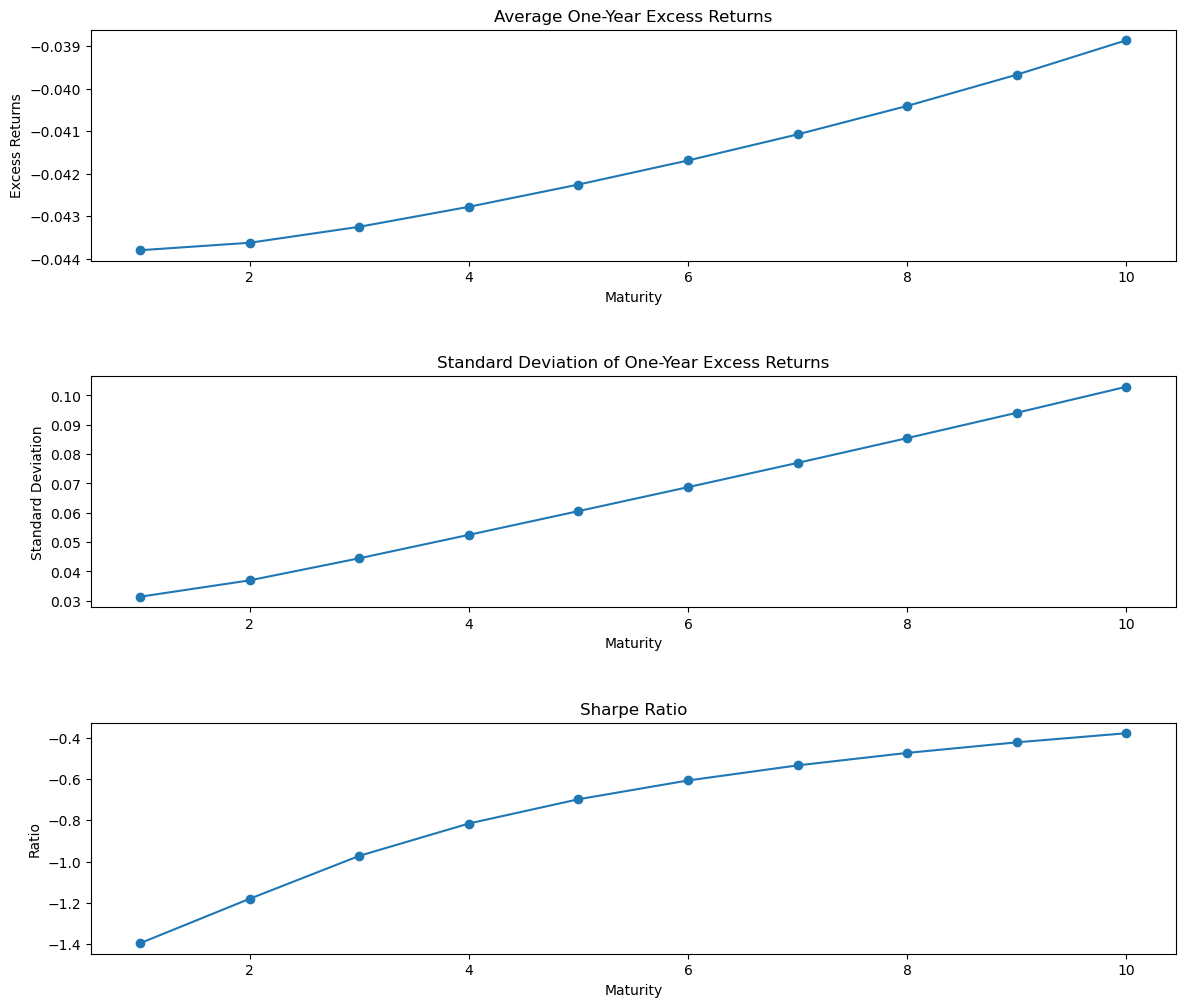

In [9]:
# calculating the excess returns correctly by taking the difference between the returns of bonds with different maturities 
# and the short rate shifted by one year
# Short rate is the shortest maturity rate 
short_rate = zeroyields[0.25]
# Shift the short rate by one year
short_rate_one_year_ago = short_rate.shift(12)
# Excess return calculation using short rate from one year ago
one_year_yield_changes = zeroyields.diff(periods=12)
previous_prices = prices.shift(periods=12)

# Calculate the one-year returns
one_year_returns = prices / previous_prices - 1
excess_returns = one_year_returns.subtract(short_rate_one_year_ago, axis=0)

excess_returns_mean = excess_returns.mean()
excess_returns_std = excess_returns.std()
maturities = zeroyields.columns
sharpe_ratio = excess_returns_mean / excess_returns_std

plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 1)
plt.plot(maturities[1:], excess_returns_mean[1:], marker='o')
plt.title('Average One-Year Excess Returns')
plt.xlabel('Maturity')
plt.ylabel('Excess Returns')

plt.subplot(3, 1, 2)
plt.plot(maturities[1:], excess_returns_std[1:], marker='o')
plt.title('Standard Deviation of One-Year Excess Returns')
plt.xlabel('Maturity')
plt.ylabel('Standard Deviation')

plt.subplot(3, 1, 3)
plt.plot(maturities[1:], sharpe_ratio[1:], marker='o')
plt.title('Sharpe Ratio')
plt.xlabel('Maturity')
plt.ylabel('Ratio')

plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

plt.show()


In [10]:
forward_rates_df = pd.DataFrame(index=zeroyields.index, columns=zeroyields.columns)

for row in range(len(zeroyields)):
    for column in range(1, len(zeroyields.columns)):
        forward_rates_df.iloc[row, column] = (zeroyields.iloc[row, column] * (column + 1) - zeroyields.iloc[row, column - 1] * column) / (column + 1 - column)

forward_rates_df = forward_rates_df.iloc[:, 1:]
zero_yields_noshort = zeroyields.iloc[:,1:]
zero_forward_spreads  =  forward_rates_df - zero_yields_noshort

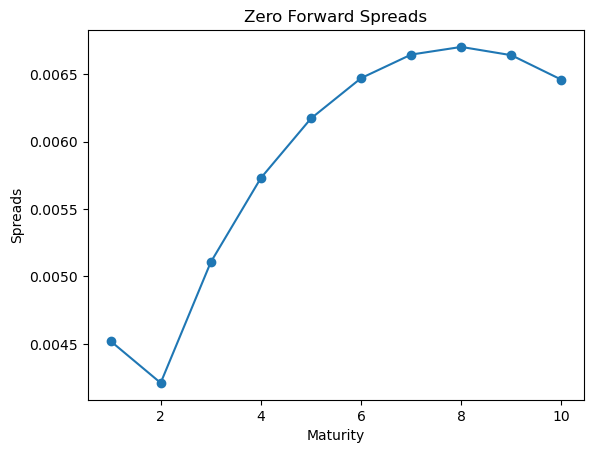

In [11]:
meanspreads = zero_forward_spreads.mean()
plt.plot(maturities[1:], meanspreads, marker='o')
plt.title('Zero Forward Spreads')
plt.xlabel('Maturity')
plt.ylabel('Spreads')

plt.show()

In [12]:
one_year_returns_cleaned = one_year_returns.dropna(how='all')
one_year_returns_cleaned = one_year_returns_cleaned.iloc[:, 1:].astype(float)
zero_forward_spreads_cleaned  = zero_forward_spreads.iloc[12:].astype(float)
one_year_yield_changes_cleaned = one_year_yield_changes.dropna(how='all')
one_year_yield_changes_cleaned = one_year_yield_changes_cleaned.iloc[:, 1:].astype(float)

In [13]:
#Regression A

# Define the variables for regression
y = one_year_returns_cleaned.values.flatten()  # one-year returns
X = zero_forward_spreads_cleaned.values.flatten()  # forward-spot spreads

# Add constant term to independent variable
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(y, X)
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     945.8
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          1.56e-195
Time:                        10:08:18   Log-Likelihood:                 10122.
No. Observations:                7380   AIC:                        -2.024e+04
Df Residuals:                    7378   BIC:                        -2.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0165      0.001    -17.749      0.0

In [14]:
#Regression B 

# Define the variables for regression
y = one_year_yield_changes_cleaned.values.flatten()  # one-year returns
X = zero_forward_spreads_cleaned.values.flatten()  # forward-spot spreads

# Add constant term to independent variable
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(y, X)
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     967.6
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          1.02e-199
Time:                        10:08:18   Log-Likelihood:                 22319.
No. Observations:                7380   AIC:                        -4.463e+04
Df Residuals:                    7378   BIC:                        -4.462e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.000     20.465      0.0

In [15]:
# Regression A for n =2 

# Define the variables for regression
y = one_year_returns_cleaned[2].values  # one-year returns
X = zero_forward_spreads_cleaned[2].values  # forward-spot spreads

# Add constant term to independent variable
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(y, X)
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     137.5
Date:                Sun, 11 Feb 2024   Prob (F-statistic):           3.13e-29
Time:                        10:08:18   Log-Likelihood:                 1671.8
No. Observations:                 738   AIC:                            -3340.
Df Residuals:                     736   BIC:                            -3330.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0072      0.001     -6.481      0.0

In [16]:
#Regression B for n =2 

# Define the variables for regression
y = one_year_yield_changes_cleaned[2].values  # one-year returns
X = zero_forward_spreads_cleaned[2].values  # forward-spot spreads
# Add constant term to independent variable
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(y, X)
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     144.0
Date:                Sun, 11 Feb 2024   Prob (F-statistic):           2.02e-30
Time:                        10:08:18   Log-Likelihood:                 2137.0
No. Observations:                 738   AIC:                            -4270.
Df Residuals:                     736   BIC:                            -4261.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      6.960      0.0

In [25]:
#Pre-1985
pre_1985_returns = one_year_returns_cleaned.loc[:'1984']
pre_1985_yieldchanges = one_year_yield_changes_cleaned.loc[:'1984']
pre_1985_zero_forward_spreads = zero_forward_spreads_cleaned.loc[:'1984']

In [28]:
#Regression A

# Define the variables for regression
y = pre_1985_returns.values.flatten()  # one-year returns
X = pre_1985_zero_forward_spreads.values.flatten()  # forward-spot spreads

# Add constant term to independent variable
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(y, X)
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     643.2
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          1.67e-127
Time:                        10:14:29   Log-Likelihood:                 3914.3
No. Observations:                2710   AIC:                            -7825.
Df Residuals:                    2708   BIC:                            -7813.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0287      0.001    -23.973      0.0

In [29]:
#Regression B

# Define the variables for regression
y = pre_1985_yieldchanges.values.flatten()  # one-year returns
X = pre_1985_zero_forward_spreads.values.flatten()  # forward-spot spreads

# Add constant term to independent variable
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(y, X)
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     892.7
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          8.81e-170
Time:                        10:14:32   Log-Likelihood:                 8293.0
No. Observations:                2710   AIC:                        -1.658e+04
Df Residuals:                    2708   BIC:                        -1.657e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.000     27.271      0.0

In [31]:
#Post-1985
post_1985_returns = one_year_returns_cleaned.loc['1985':]
post_1985_yieldchanges = one_year_yield_changes_cleaned.loc['1985':]
post_1985_zero_forward_spreads = zero_forward_spreads_cleaned.loc['1985':]

In [32]:
#Regression A

# Define the variables for regression
y = post_1985_returns.values.flatten()  # one-year returns
X = post_1985_zero_forward_spreads.values.flatten()  # forward-spot spreads

# Add constant term to independent variable
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(y, X)
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     236.8
Date:                Sun, 11 Feb 2024   Prob (F-statistic):           3.69e-52
Time:                        10:15:19   Log-Likelihood:                 6340.6
No. Observations:                4670   AIC:                        -1.268e+04
Df Residuals:                    4668   BIC:                        -1.266e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.001     -2.349      0.0

In [33]:
#Regression B

# Define the variables for regression
y = post_1985_yieldchanges.values.flatten()  # one-year returns
X = post_1985_zero_forward_spreads.values.flatten()  # forward-spot spreads

# Add constant term to independent variable
X = sm.add_constant(X)

# Run the regression
model = sm.OLS(y, X)
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     178.9
Date:                Sun, 11 Feb 2024   Prob (F-statistic):           4.47e-40
Time:                        10:15:34   Log-Likelihood:                 14244.
No. Observations:                4670   AIC:                        -2.848e+04
Df Residuals:                    4668   BIC:                        -2.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.181      0.0